# RSCAM Assessment 3

## Neural Networks

In this lab we will learn a little about the training process for neural networks.  Before beginning this lab you *must* review the materials in Lectures 5 and 6 (see slides/video on the RSCAM Learn page).  The lab builds directly on the examples (XOR and SPD Classifier) which are introduced in the lecture.

One note about the problems this week.  In some of the examples there are parameters that influence the size of the computational task involved.  For example a large number of timesteps (or, equivalently, a small timestep on a fixed time interval) will mean that you have to do a lot of computational work.  Changing the number of nodes in a neural network or increasing the size of the data set will each add to the computational effort.  Remember that you can usually halt an execution using the "Kernel" menu in Jupyter Notebooks.  As you are performing the exercises always try to run smaller models first and build up to more complicated cases so that you can estimate the execution time.  Juggling the computational load with the accuracy obtained is a real life challenge that we confront whenever we are performing scientific computing tasks so it is not a bad thing to start to get used to it.

## Simulating logic gates
Binary logical operations like AND, OR, NAND, XOR... are the bread and butter of modern digital devices.  Although it is not of direct practical relevance to simulate their behavior using a neural network, it makes an interesting family of simple problems for learning about neural computation.   

As described in lecture, we can treat a logic gate as a two-input function f(x1,x2) where x1 and x2 are regarded as real numbers approximating binary states (0 or 1) and the output is also an approximation of a binary state.   Here we will use a two-layer network (one hidden layer with two nodes) and the sigmoidal function for both activation and output gates.   To use this within the setting of an Euler method we need to be able to compute a loss function L(theta), where theta is a vector of parameters of the network, and its negative gradient F=-nabla L.   These calculations are performed by the following code.
 

In [141]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
font = {'family' : 'helvetica','size'   : 16}
plt.rc('font', **font)  # gives bigger fonts

def sig_act(s):
    return 1.0/(1.0+math.exp(-s))

def sig_act_prime(s):
    return math.exp(-s)/(1.0+math.exp(-s))**2

def p_force(theta):

# Calculate negative gradient of L2 loss function (and the loss) for 
# a two input function modelled with a two layer (2 hidden node) network
# using sigmoidal activation
# input - parameter vector *theta*
# output - negative gradient of L2 loss *F* and *loss*

    #change to weight, bias notation
    w11 = theta[0]; w12 = theta[1]; w21 = theta[2]; w22 =theta[3]
    w31 = theta[4]; w32 = theta[5]; b1 = theta[6]; b2=theta[7]; b3=theta[8]
    g = np.zeros((9,1));           # g = gradient - start with a zero vector 
    loss = 0                       # training loss

    for i in range(len(tdata)):
        x1 = tdata[i][0]; x2 = tdata[i][1]; c = tdata[i][2];
   
        # calculate intermediates and output of network
        u1 = w11*x1 + w12*x2 + b1
        u2 = w21*x1 + w22*x2 + b2
      
        z1 = sig_act(u1)            # hidden node outputs
        z2 = sig_act(u2)
        u3 = w31*z1 + w32*z2 +b3    # 2nd layer
        
        out = sig_act(u3)
        res = c-out
        loss = loss + res**2        # update the L2 loss
        
        # now calculate the loss gradient components in reverse order
        h3 = -2*res*sig_act_prime(u3) 
        
        g[8] += h3                  # deriv with respect to bias b3
        g[5] += h3*z2               # wrt w31
        g[4] += h3*z1               # wrt w32
        
        h2 = h3* sig_act_prime(u2)  # multipliers
        h1 = h3* sig_act_prime(u1)
        
        g[7] += h2*w32              # wrt b2
        g[6] += h1*w31              # wrt b1
        g[3] += h2*w32*x2           # wrt w22
        g[2] += h2*w32*x1           # wrt w21
        g[1] += h1*w31*x2           # wrt w12
        g[0] += h1*w31*x1           # wrt w11

# negate the gradient to get the descent direction

    F = -g

    return F,loss

This code can be used to model any two-input function with an output between 0 and 1.

Note the following:
<ul>
    <li> that the data is provided in a global array tdata which has k rows and in each row 3 elements: x1, x2, c, where c is the prescribed value of the function at the point (x1,x2);</li>
    <li> that the code begins by translating the vector theta of all parameters into the various parameter names (wij, the weights, and b_i, the biases) according to the diagram you can find for the XOR gate in the slides of lectures 5 and 6.</li>
    <li> that the code automatically determines the length of the tdata array and this can be arbitrarily long; </li>
    <li> the computation is handled in two steps for each data point.  First the network nodes are sequentially calculated (from left to right), then the components of the gradient are calculated for right to left, i.e. in reverse order.</li>
    <li> that both the negative gradient (summed over the data) and the loss are computed by this function.</li>
    </ul>

### Exercise 1 
Test out the code as follows.  Define an array tdata of the following form:
$$ \textrm{tdata} =\left [ \begin{array}{ccc} 0 & 0  & 0\\0 & 1 & 1\\1 & 0 & 1\\1& 1 & 1\end{array}\right ].$$  (Notice that this is the logic table of a logical OR gate.)  Set the parameter values as follows: (a) $\theta=0$ (the zero vector in 9 dimensions).  (b) $\theta =[0,0,0,0,0,2\log_e(3),100,0,0]$.  What is the value you obtain for the loss and gradient vector in each of cases (a) and (b)?  (c) Does the loss value in each case agree with what you expect? (d) In example (a) give a vector in parameter space in the direction of which you would expect the loss to decrease and briefly (one sentence) explain why this is the case. (2 marks)


In [ ]:
tdata = # !...

## Euler's Method
Euler's method can be used to numerically integrate the gradient system for the neural network.  The following codes are similar to methods that have been given earlier in the course. They are simply modified to pass and store the loss values as well as the vector field.  Study the codes and make sure that you understand what they are doing.

In [143]:
def Euler(q_n, h, vector_field):
# computes a step using Euler's method for the given vector field
    F,loss = vector_field(q_n)
    return q_n + h*F, loss


In [144]:
def compute_trajectory( q0, Nsteps, h,  step_function, vector_field):
# computes a trajectory of length *Nsteps*
# for a differential equation defined by *vector_field*
# starting from a given initial condition *q0*
# using a given method defined by *step_function*
# with stepsize *h*
#
# outputs independent variable values *t_traj*, 
# trajectory *q_traj* whose jth column is the solution at time level j

    # initialize trajectory
    q_traj = [q0]; t_traj = [0]
    F,loss = vector_field(q0)
    loss_traj = [loss]

    # starting values
    q = q0; t = 0
    
    # loop
    for n in range(Nsteps):
        # calculate next step using provided stepping function
        q,loss  = step_function(q, h,  vector_field)
        t +=  h

        # update trajectory
        q_traj.append(q)
        t_traj.append(t)
        loss_traj.append(loss)

    return q_traj, t_traj, loss_traj

Notice that the code will accept as inputs a vector field (vector_field) and a method (step_function), as well as a stepsize, initial state, and number of timesteps.  The code outputs q_traj, an array whose columns are the steps in parameter space, t_traj, a corresponding sequence of time levels and loss_traj which is the training loss computed at each of the points.   

We next specify the OR gate by prescribing the tdata array as mentioned above. 

In [145]:
tdata = np.asarray([[0,0,0],[0,1,1],[1,0,1],[1,1,1]])

### Exercise 2 
Let us attempt to train the network to solve the OR gate.    (a) Compute a trajectory for the neural network by calling the compute_trajectory code.  You should start with an initial random vector which you can obtain by q0 = np.random.random((9,1)).  Use a stepsize of 0.1 and take 100 steps.   (b) plot the training loss as a function of time along this trajectory.    (c) change the stepsize to  1 and repeat steps (a) and (b).  (d) For the stepsize of 1, change the number of steps to 1000 and repeat steps (a) and (b).  Briefly discuss the graphs--what do you think they tell us about the learning process in this case? (marks 2)

In the next part, we will look at the classifier obtained by training the perceptron model for an OR gate. To do this, we will want to graph the function defined by the perceptron (for varying inputs x1, x2) for given parameter values.  This can be achieved by making a surface plot or by using pcolor. 

The first step is to program the raw classifier as an input-output relation.  The code is like the first part of the gradient calculation but here the x1,x2 values are inputs not prescribed data points.  The theta vector is assumed to be provided.


In [150]:
def p_classifier(x1,x2,theta):
# compute 2-layer planar perceptron classifier for given inputs x1, x2
# parameter theta: a nine component vector

# change to weight, bias notation
    w11 = theta[0]; w12 = theta[1]; w21 = theta[2]; w22 =theta[3]
    w31 = theta[4]; w32 = theta[5]; b1 = theta[6]; b2=theta[7]; b3=theta[8]

    u1 = w11*x1 + w12*x2 + b1
    u2 = w21*x1 + w22*x2 + b2
      
    z1 = sig_act(u1)            # hidden node outputs
    z2 = sig_act(u2)
    u3 = w31*z1 + w32*z2 +b3    # 2nd layer
        
    
    out = sig_act(u3)         # output

    return(out)

Once we have the classifier coded, it is a simple matter of generating a grid of points and evaluating the classifier at each gridpoint.  Functions to do these tasks are given below.

In [151]:
def grid_points(rectangle,delx):
    a = rectangle[0]; b=rectangle[1]; c=rectangle[2]; d=rectangle[3]
    x1 = np.arange(a, b+delx, delx)
    x2 = np.arange(c, d+delx, delx)
    x1grid, x2grid = np.meshgrid(x1, x2)
    return x1grid,x2grid

def compute_classifier(x1grid,x2grid,theta):
    # draw a 3-d plot of the classifier generated by
    # the 2-layer pereceptron network
    # domain defined by *rectangle* [a,b,c,d] a<=x1<=b; c<=x2<=d
    # *delx*: increment in each variable (fineness of grid used for plotting)
    # *theta*: parameter vector
    dims = x1grid.shape
    n1 = dims[0]; n2 = dims[1]
    zgrid = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            zgrid[i,j] = p_classifier(x1grid[i,j],x2grid[i,j],theta)
    return zgrid

### Exercise 3
Using the codes above, create  pcolor plots (or surface plots) showing the classifiers at the beginning and end of the trajectory computed in Exercise 2e (h=1, N=1000 steps).  You should use the scatter plot capability to visualise the 4 data points that define the OR gate in relation to the pcolor or surface plot (and maybe color them according to opposite of their binary value, 0 or 1, to show a contrast with the classifier). Discuss the graphs obtained and what it tells you about the trained network. (2 marks)

### Exercise 4
*This exercise is open ended and individual.*
 
You are now ready to turn your attention to the XOR gate using the same perceptron model. 

Using the ideas and methods presented above discuss the training of a perceptron model of the XOR gate using gradient descent.   Explore issues such as convergence of the learning process and accuracy of the learned classifier.  Include at least a paragraph of discussion. There is no prescibed model for the solution to this question but you should be careful to justify any statements you make using numerical tests.

Please limit the number of graphs provided with your answer to at most 4 and any written text to at most about 200 words. (4 marks)

## SPD Classifier
In the remainder of this assessment we will turn our attention to the SPD matrix classifier which determines, for a matrix of a given class, whether or not the matrix is symmetric positive definite.   Recall that the eigenvalues of a symmetric matrix are all real numbers.   The criterion for a matrix to be SPD is that the spectrum of the matrix (set of all eigenvalues) lies strictly in the right half line ($\mathbb{R}_+ = \{x|x\geq 0\}$).  Equivalently, we can check if a given symmetric matrix $A$ is SPD by checking if $\lambda_{\rm min}(A)>0$.

We will set up the SPD classifier as described in Lecture 6.  We restrict ourselves for this purpose to matrices of the form
$$ A = \left [ \begin{array}{ccc} 1 & a & b\\a & 1 & c\\b & c & 1\end{array}\right ]$$

Although there is nothing that would restrict us from applying the same methodology to much larger matrices, or to matrices having a particular sparsity structure, the simplification will keep the computational task more or less manageable without having to use special software frameworks for efficiency.  However, to note, it is still easily possible to overwhelm the computational capabilities of your laptop computer when running the codes described here.   

To begin we need to write routines for the activation function and the output function.  We will use ReLU activation and sigmoidal output, although these choices are not essential and other choices could easily be explored.  

In [235]:
def phi_a(s):
    return s*(s >= 0)

def phi_a_prime(s):
    return 1*(s >= 0)

def phi_o(s):
    return 1.0/(1.0+math.exp(-s))

def phi_o_prime(s):
    return math.exp(-s)/(1.0+math.exp(-s))**2

Note: the way the ReLU is programmed is a little unusual--for input s it is given as a product of s and a conditional expression which we normally think of as evaluating to true or false!  In python we are using a trick here that a logical expression can be 'recast' as an integer value (0 or 1) by simply combining it with a number through an arithmetic operation such as multiplication.  We have also used the fact that the 'product' of two python vectors of the same size is another vector of the same size whose elements are formed by taking the products of the corresponding elements.   An advantage of writing the formula in this way is that it is automatically 'vectorised', meaning that I can apply it to a vector and get a vector of results back.  If i used a more standard "if then else" approach it would not be possible to do this!  

### Exercise 5
We are now ready to code the force (negative gradient) in the case of the SPD classifier problem.  A template code is given below which you need to edit to implement the formulas given in Lecture 6.    The parts indicated below in the SPD_force routine that are missing compute the following partial derivatives:  g_z (partial gradient of loss with respect to the vector of hidden nodes), g_u (partial gradient with respect to the first intermediate u=Wx+b), g_W (partial gradient with respect to matrix argument W-- the weights in the first layer), g_b (partial gradient with respect to biases in the first layer).  Study Slide 18  of Lecture 6 and fill in these missing pieces. (2 marks)

In case it is unclear, the notation g_W refers to the matrix whose elements are the partial derivatives with respect to each of the components of W, arranged in the same shape as W.

Note that the number of hidden layer nodes m need not be passed in explicitly.  It can be figured out from the dimension of theta as long as theta is of the correct form (5m+1 dimensional).  This just simplifies the calling sequence, but we need to check that the dimension indeed is of this form, as shown in the code.


In [ ]:
def SPD_force(theta):
    d = len(theta)
    # we assume d = 3xm +m + m + 1 = 5m+1
    # check this!
    if (d-1) %5 != 0:
        print('failure - wrong dimension - theta must be a 5m+1 dimensional vector')
        raise
    
    m = (d-1)//5                       # number of internal (hidden layer) nodes
    W = theta[0:3*m]
    W = np.reshape(W,((m,3)))          # reshape the weight matrix for the hidden layer
    wo = theta[3*m:4*m]                # separate the weights of the output layer
    b = theta[4*m:5*m]                 # biases of the hidden layer
    bo = theta[5*m]                    # bias of the output layer
    
    loss = 0                           # loss
    g = np.zeros((5*m+1,1))            # gradient
    
    # sum over training data 
    for i in range(len(tdata)):
        xi = np.reshape(tdata[i, 0:3],((3,1)))
        ci = tdata[i,3]
        u = W @ xi + b
        z = phi_a(u)
        uo = np.transpose(wo) @ z + bo
        c = phi_o(uo)
        
        res = c-ci                     # swapped from xor example where we had (ci-c)^2
        loss += res**2
        
        g_o = 2*res*phi_o_prime(uo)    # the gradient implemented just as in slides of L6
        g_bo = g_o
        g_uo = g_o
        g_wo = g_o*z
        
        g_z = # ! Your code here
        g_u = # ! Your code here
        g_W = # ! Your code here
        g_b = # ! Your code here
        
        gg = np.vstack((np.reshape(g_W,((3*m,1)))))
        gg = np.vstack((gg,g_wo))
        gg = np.vstack((gg,g_b))
        gg = np.vstack((gg,g_bo))
        g += gg
        
    return -g,loss

It is a good idea to also code up the classifier as a function which can be applied to an input x =[[a],[b],[c]] describing the matrix, where it is assumed that all the parameters are given.  We provide this in the function SPD_classifier, below.

In [238]:
def SPD_classifier(a,b,c,theta):
# compute 2-layer SPD classifier for given input matrix with coefficients defined by (a,b,c)
# parameter theta: a 5*m+1 component parameter vector
    d = len(theta)
    # we assume d = 3xm +m + m + 1 = 5m+1
    # check this!
    if (d-1) %5 != 0:
        print('failure - wrong dimension - theta must be a 5m+1 dimensional vector')
        raise
    
    x = np.asarray([[a],[b],[c]])
    m = (d-1)//5                       # number of internal (hidden layer) nodes
    W = theta[0:3*m]
    W = np.reshape(W,((m,3)))          # reshape the weight matrix for the hidden layer
    wo = theta[3*m:4*m]                # separate the weights of the output layer
    b = theta[4*m:5*m]                 # biases of the hidden layer
    bo = theta[5*m]                    # bias of the output layer
    u = W @ x + b
    z = phi_a(u)
    uo = np.transpose(wo) @ z + bo
    c = phi_o(uo)
    return(c)

### Exercise 6 
It is time to generate our data set.  You will write a function for this purpose.   

The matrices are described by three coordinates (a,b,c) and an output class label l (l=1 if SPD, l=0 otherwise).    We wish to generate the matrices randomly, so we need to compute random values of (a,b,c) that are uniformly distributed in the interval [-1,1]. The function np.random.random((n1, n2)) creates a matrix of dimensions n1 rows and n2 columns, each of whose elements are uniformly distributed random numbers in the interval [0,1].   The function np.linalg.eigvals(A) computes the vector of all the eigenvalues of a square matrix A.  Using these two routines, right code to construct an array tdata of given length of the form
$$ \textrm{tdata} = \left [ \begin{array}{cccc} a_1 & b_1 & c_1 & l_1\\
a_2 & b_2 & c_2 & l_2\\
a_3 & b_3 & c_3 & l_3\\
\vdots & \vdots & \vdots & \vdots \\
a_k & b_k & c_k & l_k
\end{array}
\right ]
$$
$l_j$ is the class label which is just 0 if the corresponding matrix (with 1s on the diagonal) is not SPD and 1 if it is SPD. (2 marks)

Now use your generate_data code to create a training data set by the line

    tdata = generate_data(50)

50 is the number of rows in tdata and thus the size of the data set.  This might not be enough! Remember that each one of these data points will make a contribution to the loss function and to the gradient, so if we have too many elements in the data set the computational costs will become large.  As a rule you should probably work with data sets up to at most a few hundred training points in most of your calculations. (Of course if you wish to explore a larger one you could let the program run overnight on your computer!!)

Finally, once you have created tdata, you will be able to attempt to train our classifier using compute_trajectory, the Euler method for the step_function, and the SPD_force function that we produced above.   

Note that the only place the number of hidden nodes of the network is specified is in the dimension of the parameter vector. This dimension should be 5m+1, in which case m is the number of hidden nodes.  Below we use 51 for this dimension so there are 10 nodes in the hidden layer.  Again the choice of a larger number of nodes (by specifying a larger parameter vector) will lead to greater computational costs.

In the graph shown below, we plot the training loss against the time.  It is important to note that the actual training loss curve will be very different depending on the training data and the initial condition, both of which are random!  This means you might want to re-run the method several times to get a better understanding of how it is working.

In [240]:
tdata = generate_data(50)
theta,t,loss = compute_trajectory(np.random.random((51,1)),1000,.1,Euler,SPD_force)

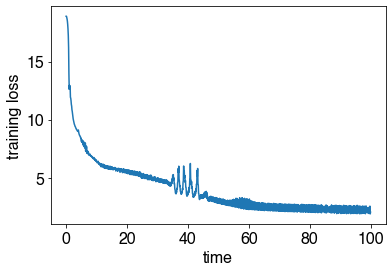

In [241]:
plt.plot(t,loss)
plt.xlabel('time'); plt.ylabel('training loss')
plt.show()

### Exercise 7 
Notice that--surprisingly--the training loss increases as well as decreases along the trajectory!  Why might this happen?  Recall that the gradient descent flow (the differential equation) has the property that the loss is a monotone decreasing function.  Give an explanation here for the loss of monotonicity.  (1 mark)

The fact that the training loss decreases (eventually), means that we gain high accuracy on the training set.  There is, however, the important question of how the classifier performs on unseen 'test' data.  

To examine this, generate a new sample of test data (another tdata array with, say, 100 rows) and calculate the value of the classifier for each element.  Compare this with the actual label (determined using the eigenvalue test).   You may wish to plot the classification errors using plt.bar (which produces a bar graph).  Discuss the result. (1 marks)

### Exercise 8
This part is free form and individual.

Explore the SPD classification network by using numerical experiments.   You should adjust the network size, the data set size, the number of iterations and the stepsize in order to understand how these alter the convergence or change the results of classification (and the error on test data).  What is the best result you can achieve?   (Explain what "best" means!)

You may wish to consider any of the following issues and aspects in your discussion.

<ul>
    <li> the accuracy on the training data, in relation to the number of nodes in the hidden layer, or number of training data points, or training iterations </li>
    <li> the accuracy of the trained network on test data, in relation to the number of nodes in the hidden layer, or number of training data points, or training iterations </li>
    <li> the use of subsampling from the training data, as mentioned in Lecture 6, in which the SPD_force is modified so that a randomly chosen subset of the training data is used to compute the loss at each step (rescaled by the ratio of the size of the training set to the size of the subsampled training set). </li>
    <li> the choice of initial parameters used and its effect on the results obtained, or dependence on the data set used </li>
    </ul>

(Any *one* of these would be interesting!)

Please limit the number of graphs provided with your answer to at most 4 and any written text to at most about 200 words. (4 marks)